In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from trajectory.segments import * 
from trajectory.planner import * 
from trajectory.plot import * 
from trajectory.trapmath import * 
import matplotlib.pyplot as plt
from IPython.display import display
import trajectory as tj
import pandas as pd
import numpy as np
from math import sqrt
from random import randint, random
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [358]:
a_max = 30_000
v_max = 5_000

def x_ad(v_0, v_c, v_1, a_max):
    x_a, t_a = accel_tx(v_0, v_c, a_max)
    x_d, t_d = accel_tx(v_c, v_1, a_max)
    
    return t_a + t_d,  x_a + x_d

def make_ad(v_0, v_1, a_max):
    def f(v_c):
        return x_ad(v_0, v_c, v_1, a_max)

    return f
    
rows = []

from itertools import product

vels = np.linspace(0,v_max,num=25)

for v_c in range(0,v_max, 10):
    
    for v_0, v_1 in set(list(product(vels, vels))):
        #v_0, v_1 = list(sorted([v_0, v_1]))
        t, x =  x_ad(v_0, v_c, v_1, a_max)
        d = {'v_c':v_c,'t':t,'x':x, 'v_0': v_0, 'v_1':v_1}
        
        
        rows.append(d)

df = pd.DataFrame(rows)
df['t'] = df.t.round(3)
df['x'] = df.x.round(0)
df['xr'] = df.x.round(-1)
df['v_m'] = (df.v_0+df.v_1)/2
         

In [227]:
 
fig, ax = plt.subplots(figsize=(20,10))
sns.set(rc={"figure.figsize":(12, 8)})
sns.scatterplot(data=df, x='x',y='v_c', size=.1, markers='.', hue='t')

<AxesSubplot:xlabel='x', ylabel='v_c'>

In [257]:
dfm

,v_0,v_1,x,t,v_c,l,tml
0,0.0,0.0,0.0,0.000,520,0.00000,0.00000
1,0.0,0.0,10.0,0.021,850,0.00398,0.01702
2,0.0,0.0,20.0,0.034,1120,0.00796,0.02604
3,0.0,0.0,30.0,0.045,1310,0.01194,0.03306
4,0.0,0.0,40.0,0.053,1500,0.01592,0.03708
...,...,...,...,...,...,...,...
17851,5000.0,5000.0,460.0,0.140,1500,0.18308,-0.04308
17852,5000.0,5000.0,470.0,0.148,1310,0.18706,-0.03906
17853,5000.0,5000.0,480.0,0.155,1120,0.19104,-0.03604
17854,5000.0,5000.0,490.0,0.166,850,0.19502,-0.02902


In [260]:
np.random.randn(100)

array([-1.00774648, -0.69125916,  0.06033834,  0.77894123,  0.46473319,
        0.03890322,  0.84140811,  1.20760721,  2.06070131,  0.41421693,
       -1.8287593 , -1.88387202,  0.98699841,  1.1855424 ,  0.78384069,
        0.7460305 ,  0.29826829,  0.17923561,  1.02008071, -1.1823211 ,
        0.61917467, -0.28165579,  2.37501716, -0.50225083,  0.51320927,
       -0.23726929,  0.65130778,  0.91146279, -0.67789745, -0.29377875,
       -0.80534512, -0.03504625, -1.50447187,  1.91978308, -0.06309767,
        0.21912578,  1.72466377, -2.26220941,  0.85226199,  0.795934  ,
        1.46367508,  1.04080895,  0.34912819,  1.31851426,  0.06345337,
       -0.79685059,  1.47849429, -0.98837532, -0.31884269, -0.02277174,
       -1.03202705,  1.51916907,  0.03040371,  0.96567016,  0.23415921,
        0.17718944,  0.36158414, -0.25486761,  0.21584283, -0.23259871,
        0.46725198,  1.77773014, -1.9648551 ,  0.67333815, -0.03226172,
        0.08826251,  1.12106058,  0.12221355,  1.03642233, -1.31

In [397]:
from trajectory.trapmath import  penta_area, hex_area

df1 = df.groupby(['v_0','v_1',df.x.round(-1)]).t.min().to_frame()
df2 = df.groupby(['v_0','v_1',df.x.round(-1)]).v_c.max().to_frame()
#ax.plot( df.x, df.t,  linewidth=0, marker='.', markersize=.5)
dfm = df1.join(df2).reset_index()

dfm['v_m'] = (dfm.v_0+dfm.v_1)/2
dfm['l'] = (dfm.t.max()/dfm.x.max()) * dfm.x
dfm['tml'] = dfm.t - dfm.l

dfm['xj'] = dfm.x + (np.random.randn(dfm.shape[0])*2)


dfm['g'] = (dfm.v_c > dfm.v_0) & (dfm.v_c < dfm.v_1) 
dfm['z'] = dfm.v_0 > dfm.v_1

# t.x.max(), v_max**2/a_max, t.t.max(), 2*v_max / a_max

dfm['tn'] = dfm['t']/dfm.t.max()  #/ 2*v_max / a_max 
dfm['xn'] = dfm['xj']/dfm.xj.max() #/ v_max**2/a_max

t = dfm #[~dfm.g] #[dfm.v_c > dfm.v_m] #[dfm.x < 250]


fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=t[t.g], x='xj',y='t',  style='g', hue='v_c', palette='Blues', ax=ax)
#sns.scatterplot(data=t[~t.z], x='xn',y='tn',  style='g', size='v_0', hue='v_1', palette='Greens', ax=ax)

<AxesSubplot:xlabel='xj', ylabel='t'>

In [388]:
x = 600
z  = t[t.x.between(x-50, x+50)]

fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=z, x='v_0',y='v_1',  hue='v_c', palette='viridis', ax=ax)


<AxesSubplot:xlabel='v_0', ylabel='v_1'>

In [383]:
t.x.describe()

count    29344.000000
mean       376.885905
std        178.567825
min          0.000000
25%        240.000000
50%        370.000000
75%        500.000000
max        830.000000
Name: x, dtype: float64

In [222]:
idx = dfm[['v_0','v_1','x']].values

def find(v_0, v_1, x):
    i = np.sum((np.abs(idx-np.array([v_0, v_1,x]))/[np.mean(idx[:,0]), np.mean(idx[:,1]),np.mean(idx[:,2])]), axis=1).argmin()
    return dfm.iloc[i]

r = find(900,4300, 100)
print(r)

hex_area(r.t, r.v_0, r.v_c, r.v_1, a_max), penta_area(r.v_0, r.v_c, r.v_1, a_max)

v_0    1041.666667
v_1    4166.666667
x       160.000000
t         0.062000
v_c    4180.000000
Name: 5017, dtype: float64


(160.6668611111111, (164.9861944444444, 0.06303333333333333))

In [175]:
sns.set(rc={"figure.figsize":(12, 8)})
v_m = 2500
sns.scatterplot(data=df[(df.v_m>v_m-10)&(df.v_m<v_m+10)], x='x',y='t', size=.1, markers='.', hue='v_c')

<AxesSubplot:xlabel='x', ylabel='t'>

In [246]:
v = df.v_0.unique()[10]
t = df[(df.v_0 == v)&(df.v_1 == v)].sort_values(['x','t']).copy()
#t['x'] = t.x.round(-1)

t[t.xr==400]

,v_c,t,x,v_0,v_1,xr,v_m
307135,4910,0.113,395.0,2083.333333,2083.333333,400.0,2083.333333
307760,4920,0.113,397.0,2083.333333,2083.333333,400.0,2083.333333
308385,4930,0.114,399.0,2083.333333,2083.333333,400.0,2083.333333
309010,4940,0.114,401.0,2083.333333,2083.333333,400.0,2083.333333
309635,4950,0.115,403.0,2083.333333,2083.333333,400.0,2083.333333
310260,4960,0.115,405.0,2083.333333,2083.333333,400.0,2083.333333


In [82]:
from trajectory.trapmath import  penta_area, hex_area

t = df[(df.v_0 == 2000)&(df.v_1 == 1000)&(df.x == 40)]
for idx, r in t.iterrows():
    d = r.to_dict()
    del d['x']
    
    px = hex_area(r.t, r.v_0, r.v_c, r.v_1, a_max)
    
    x_a, t_a = accel_tx(r.v_0, r.v_c, a_max)
    x_d, t_d = accel_tx(r.v_c, r.v_1, a_max)
    
    print(  round(t_a+t_d,4) , round(px),  r.x, r.v_c, r.v_0 + a_max*t_a)

0.0324 40 40.0 690.0 3310.0
0.0324 40 40.0 691.0 3309.0
0.0323 40 40.0 692.0 3308.0
0.0323 40 40.0 693.0 3307.0
0.0322 40 40.0 694.0 3306.0
0.0322 40 40.0 695.0 3305.0
0.0322 40 40.0 696.0 3304.0
0.0321 40 40.0 697.0 3303.0
0.0321 40 40.0 698.0 3302.0
0.032 40 40.0 699.0 3301.0
0.032 40 40.0 700.0 3300.0
0.032 40 40.0 701.0 3299.0
0.0319 40 40.0 702.0 3298.0
0.0319 40 40.0 703.0 3297.0
0.0318 40 40.0 704.0 3296.0
0.0318 40 40.0 705.0 3295.0
0.0318 40 40.0 706.0 3294.0
0.0317 40 40.0 707.0 3293.0
0.0317 40 40.0 708.0 3292.0
0.0316 40 40.0 709.0 3291.0
0.0316 40 40.0 710.0 3290.0
0.0316 40 40.0 711.0 3289.0
0.0315 40 40.0 712.0 3288.0
0.0315 40 40.0 713.0 3287.0
0.0314 40 40.0 714.0 3286.0
0.0314 40 40.0 715.0 3285.0
0.0314 40 40.0 716.0 3284.0
0.0313 40 40.0 717.0 3283.0
0.0313 40 40.0 718.0 3282.0
0.0312 40 40.0 719.0 3281.0
0.0312 40 40.0 720.0 3280.0
0.0312 40 40.0 721.0 3279.0
0.0311 40 40.0 722.0 3278.0
0.0311 40 40.0 723.0 3277.0
0.031 39 40.0 724.0 3276.0
0.0246 39 40.0 2116.0 21

In [75]:
from trajectory.trapmath import  accel_tx

def f(v_0, v_c, v_1):
    x_a, t_a = accel_tx(v_0, v_c, a_max)
    x_d, t_d = accel_tx(v_c, v_1, a_max)
    
    return x_a+x_d, t_a+t_d

f(2000,690, 2000), f(2000,3293, 2000)

((70.47800000000001, 0.0524), (136.87698, 0.05172))

In [72]:
accel_tx(2000,690, a_max), accel_tx(2000,3293, a_max)

((35.239000000000004, 0.0262), (68.43849, 0.02586))

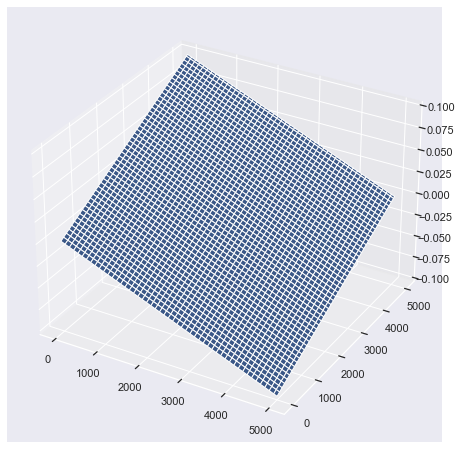

In [140]:
import seaborn as sb
import matplotlib.pyplot as plot
import numpy as np

#sb.set(rc={"figure.figsize":(10, 10)})

def f_z(v_0, v_1):
    t = (v_1 - v_0) / a_max  # Time to change from v0 to v1 at max acceleration
    x = (1/2)*a_max*t**2 + v_0*t
    
    return t


N = 50

v_0 = np.linspace(0,5000,200)
v_1 = np.linspace(0,5000,100)

v_0,v_1 = np.meshgrid(v_0, v_1)

z = f_z(v_0,v_1)

axes = plot.axes(projection='3d')
axes.plot_surface(v_0, v_1, z)
plot.show()

In [142]:

v_0.shape, v_1.shape, z.shape


((100, 200), (100, 200), (100, 200))

In [143]:
v_0

array([[   0.        ,   25.12562814,   50.25125628, ..., 4949.74874372,
        4974.87437186, 5000.        ],
       [   0.        ,   25.12562814,   50.25125628, ..., 4949.74874372,
        4974.87437186, 5000.        ],
       [   0.        ,   25.12562814,   50.25125628, ..., 4949.74874372,
        4974.87437186, 5000.        ],
       ...,
       [   0.        ,   25.12562814,   50.25125628, ..., 4949.74874372,
        4974.87437186, 5000.        ],
       [   0.        ,   25.12562814,   50.25125628, ..., 4949.74874372,
        4974.87437186, 5000.        ],
       [   0.        ,   25.12562814,   50.25125628, ..., 4949.74874372,
        4974.87437186, 5000.        ]])

In [ ]:

import seaborn as sb
import matplotlib.pyplot as plot
import numpy as np


axes = plot.axes(projection='3d')
axes.plot_surface(df.t, df.x, df.v_c)
plot.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot( t.v_0, t.v_1,  linewidth=0, marker='.', markersize=5)

In [ ]:
df.t.hist()